In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ximc import XimcRedmine

user_name = ""
password = ""

try:
    ximc_user = XimcRedmine(user_name, password)
    ximc_user.auth()
except Exception:
    print("User authorization failed")
    sys.exit(0)

# Задаем параметры для первого запроса (фильтры задаются аналогично веб-интерфейсу ximc)
ximc_user.add_filter("Проект", "соответствует", "EP-software")
ximc_user.add_filter("Статус", "соответствует", "Closed")
ximc_user.add_filter("Трекер", "не соответствует", "Bug")
ximc_user.add_filter("Приоритет", "соответствует", "Normal")
ximc_user.add_filter("Автор", "не соответствует", "dasha")
ximc_user.add_filter("Назначена", "все")
ximc_user.add_filter("Версия", "соответствует", "Развитие-2018")
ximc_user.add_filter("Тема", "содержит", "к нашим")
ximc_user.add_filter("Описание", "начинается с", "Привести")
ximc_user.add_filter("Готовность", ">=", 50)
ximc_user.add_filter("Частная", "соответствует", "нет")
ximc_user.add_filter("Файл", "отсутствует")
ximc_user.add_filter("Кем изменено", "соответствует", "mikheev")
ximc_user.add_filter("Последний изменивший", "соответствует", "VladBelov")
ximc_user.add_filter("Задача", ">=", 20033)
# Запрашиваем необходимые итоговые параметры
totals = ximc_user.get_totals("Оценка временных затрат", "Трудозатраты", "Payment cash", "Payment cashless", "Rate")
# В итоге получаем словарь в виде: {"название параметра": значение}
print("Project: EP-software")
totals_options = "Оценка временных затрат", "Трудозатраты", "Payment cash", "Payment cashless", "Rate"
table = [(option, totals[option]) for option in totals_options]
pd.set_option('display.max_columns', None)
df = pd.DataFrame(table, columns=("Параметр", "Значение"))
print(df)

# Задаем параметры для следующего запроса. Но сначала нужно очистить ранее заданные фильтры
ximc_user.clear_filters()
# Задаем фильтры аналогично веб-интерфейсу ximc
ximc_user.add_filter("Project", "is", "Payments")
ximc_user.add_filter("Status", "closed")
ximc_user.add_filter("Created", "between", "2021-09-09", "2021-11-11")
# Запрашиваем необходимые итоговые параметры
totals = ximc_user.get_totals("Estimated time", "Spent time", "Payment cash", "Payment cashless", "Rate", "Payment tail")
# В итоге получаем словарь в виде: {"название параметра": значение}
print("\nProject: Payments")
for option_name, value in totals.items():
    print(f"{option_name}: {value}")

# Задаем параметры для следующего запроса. Но сначала нужно очистить ранее заданные фильтры
ximc_user.clear_filters()
ximc_user.add_filter("Status", "is", "Closed")
ximc_user.add_filter("Tracker", "is not", "Bug")
ximc_user.add_filter("Priority", "is", "Normal")
ximc_user.add_filter("Author", "is", "dasha")
ximc_user.add_filter("Assignee", "is", "vladimirov_iy")
ximc_user.add_filter("% Done", ">=", 50)
# Запрашиваем необходимые итоговые параметры
totals = ximc_user.get_totals("Estimated time", "Spent time", "Payment cash", "Payment cashless", "Rate")
# В итоге получаем словарь в виде: {"название параметра": значение}
print("\nAll projects")
for option_name, value in totals.items():
    print(f"{option_name}: {value}")

Project: EP-software
                  Параметр  Значение
0  Оценка временных затрат      3.00
1             Трудозатраты     16.35
2             Payment cash      0.00
3         Payment cashless      0.00
4                     Rate      0.00

Project: Payments
Estimated time: 0.0
Spent time: 0.0
Payment cash: 69820.0
Payment cashless: 117322.0
Rate: 1200.0
Payment tail: 8081.0

All projects
Estimated time: 0.0
Spent time: 0.0
Payment cash: 6400.0
Payment cashless: 0.0
Rate: 500.0


In [2]:
# Имена проектов, для которых будем сравнивать данные
project_names = [project_name for _, project_name in ximc_user.get_projects()]
# Пустой массив, в который будут сохраняться данные (оценки временных затрат и трудозатраты)
estimated_times = []
spent_times = []

# Перебираем проекты из списка и получаем для них данные с применением фильтров
for project_name in project_names:
    # Задаем фильтры аналогично веб-интерфейсу ximc
    ximc_user.clear_filters()
    ximc_user.add_filter("Project", "is", project_name)
    ximc_user.add_filter("Status", "is", "Closed")
    ximc_user.add_filter("Tracker", "is not", "Bug")
    ximc_user.add_filter("Created", ">=", "2021-06-01")

    # Запрашиваем необходимые итоговые параметры
    totals = ximc_user.get_totals("Оценка временных затрат", "Трудозатраты")
    if totals["Оценка временных затрат"] is None:
        estimated_times.append(0)
    else:
        estimated_times.append(totals["Оценка временных затрат"])
    if totals["Трудозатраты"] is None:
        spent_times.append(0)
    else:
        spent_times.append(totals["Трудозатраты"])

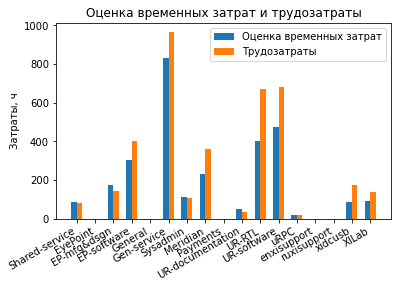

In [4]:
# Построение графика
fig, ax = plt.subplots()
x = np.arange(len(project_names))
width = 0.3
ax.bar(x - width / 2, estimated_times, width, label="Оценка временных затрат")
ax.bar(x + width / 2, spent_times, width, label="Трудозатраты")
ax.set_xticks(x)
ax.set_xticklabels(project_names)
ax.set_title("Оценка временных затрат и трудозатраты")
ax.set_ylabel("Затраты, ч")
ax.legend()
fig.autofmt_xdate()
plt.show()

In [6]:
# Создание таблицы
table = [(project_name, estimated_times[i], spent_times[i]) for i, project_name in enumerate(project_names)]
pd.DataFrame(table, columns=("Проект", "Оценка временных затрат, ч", "Трудозатраты, ч"))

,Проект,"Оценка временных затрат, ч","Трудозатраты, ч"
0,Shared-service,85.0,79.35
1,EyePoint,0.0,0.00
2,EP-mfg&dsgn,176.0,143.95
3,EP-software,300.5,401.45
4,General,0.0,0.00
5,Gen-service,830.5,963.96
6,Sysadmin,112.0,104.75
7,Meridian,232.0,360.06
8,Payments,0.0,0.00
9,UR-documentation,50.0,34.80


In [8]:
# Получаем ID и названия всех проектов в ximc
projects = ximc_user.get_projects()
pd.DataFrame(projects, columns=("ID", "Проект"))

,ID,Проект
0,202,Shared-service
1,66,EyePoint
2,86,EP-mfg&dsgn
3,85,EP-software
4,71,General
5,72,Gen-service
6,113,Sysadmin
7,109,Meridian
8,69,Payments
9,80,UR-documentation
